calculate mult

In [10]:
loadlevel = 0.5

graphnamelist = ["dring","ls","rrg"]
swlist = range(40,121,20)
filenameprefix = "/home/annzhou/DRing/src/emp/datacentre/scalegraphfiles/"
flowfilenameprefix = "/home/annzhou/DRing/src/emp/datacentre/flowfiles/c2s_"
for sw in swlist:
    for graphname in graphnamelist:
        if graphname=="dring":
            filename = f"{filenameprefix}dring_deg{int(sw*0.8)}_sw{sw}_sn12_i1.edgelist"
        elif graphname=="rrg":
            filename = f"{filenameprefix}rrg_deg{int(sw*0.8)}_sw{sw}_svr{(sw//5)*(sw//5)*12}_os1_i1.edgelist"
        elif graphname=="ls":
            filename = f"{filenameprefix}ls_x{int(sw*0.6)}_y{sw//5}_i1.edgelist"
        with open(filename,'r') as f:
            numlink = len(f.readlines())
            
        flowfile = f"{flowfilenameprefix}{(sw//5)*(sw//5)*12}_{sw}_{int(sw*0.8)}_{int(sw*0.8)}_{int(sw*0.8)}_1_0_0_0"
        bytespermult = 0
        with open(flowfile,'r') as f:
            lines = f.readlines()
            for line in lines:
                tokens = line.split(',')
                bytespermult += int(tokens[2])
            
        bytesperlink = 894784*1500*0.2 # 894784 packets per second, 1500B per packet, 200ms
        totalbytes = bytesperlink*numlink # *2 for 2 directions, /2 for 2 hops per flow
        usablebytes = totalbytes*loadlevel
        mult = usablebytes/bytespermult
        print(f"{filename}: {mult}")

/home/annzhou/DRing/src/emp/datacentre/scalegraphfiles/dring_deg32_sw40_sn12_i1.edgelist: 1.7988793812578656
/home/annzhou/DRing/src/emp/datacentre/scalegraphfiles/ls_x24_y8_i1.edgelist: 1.744367884856112
/home/annzhou/DRing/src/emp/datacentre/scalegraphfiles/rrg_deg32_sw40_svr768_os1_i1.edgelist: 1.744367884856112
/home/annzhou/DRing/src/emp/datacentre/scalegraphfiles/dring_deg48_sw60_sn12_i1.edgelist: 0.8105349078012889
/home/annzhou/DRing/src/emp/datacentre/scalegraphfiles/ls_x36_y12_i1.edgelist: 0.7781135114892374
/home/annzhou/DRing/src/emp/datacentre/scalegraphfiles/rrg_deg48_sw60_svr1728_os1_i1.edgelist: 0.7781135114892374
/home/annzhou/DRing/src/emp/datacentre/scalegraphfiles/dring_deg64_sw80_sn12_i1.edgelist: 0.45262717567355276
/home/annzhou/DRing/src/emp/datacentre/scalegraphfiles/ls_x48_y16_i1.edgelist: 0.43561111643770495
/home/annzhou/DRing/src/emp/datacentre/scalegraphfiles/rrg_deg64_sw80_svr3072_os1_i1.edgelist: 0.43561111643770495
/home/annzhou/DRing/src/emp/datacentre

generate conffile

In [22]:
graphname = "dring"
routingname = "su2"
rt1 = "su"
rt2 = 2
swlist = range(40,121,20)
dringserverlist = [752,1680,2992,4672,6720]
# multlistarr = [[1,5,100],[0,47,100],[0,26,100],[0,17,100],[0,12,100]]
multlistarr = [[1,74,100],[0,78,100],[0,44,100],[0,28,100],[0,19,100]]
sseedarr = range(2,6)

conffile = f"/home/annzhou/DRing/src/emp/datacentre/experiments/scalability/fifty.conf"
with open(conffile,'w') as f:
    for inumsw,numsw in enumerate(swlist):
        multlist = multlistarr[inumsw]
        multstr = f"{multlist[0]}_{multlist[1]}_{multlist[2]}"
        numlsserver = (numsw//5)*(numsw//5)*12
        numport = int(numsw*0.8) # == numleaf
        numdringserver = dringserverlist[inumsw]
        trafficfile = f"flowfiles/c2s_{numlsserver}_{numsw}_{numport}_{numport}_{numport}_{multstr}_0"
        lsqvarfile = f"qvarfiles/qvar_leafspine_{numlsserver}_{numsw}_{numport}_0_0_ecmp_64"
        lsnetpathfile = f"netpathfiles/netpath_ecmp_leafspine_{numlsserver}_{numsw}_{numport}"
        dringqvarfile = f"qvarfiles/qvar_{graphname}_{numdringserver}_{numsw}_{numport}_0_0_{routingname}_c2s_{numport}_{numport}_0_{multstr}_2_0_64"
        dringnetpathfile = f"netpathfiles/netpath_{routingname}_{graphname}_{numdringserver}_{numsw}_{numport}"
        dringscalegraphfile = f"scalegraphfiles/dring_deg{numport}_sw{numsw}_sn12_i1.edgelist"
        dringserverfile = f"serverfiles/dring_{numdringserver}_{numsw}_{numport}"
        makeleafspine = "MAKE"
        makedring = "MAKE"
        for sseed in sseedarr:
            f.write(f"./run.sh LEAFSPINE {makeleafspine} {numsw} {numlsserver} {numport} leafspine_sw{numsw} NEW_FILE null {multlist[0]} {multlist[1]} {multlist[2]} 0 0 0 0 0 0 ecmp 0 {trafficfile} null {sseed} {lsnetpathfile} {lsqvarfile} 64 50 150 200 0 0 > m_scalability_leafspine_{numsw}_{sseed}.log\n")
            f.write(f"./run.sh RRG {makedring} {numsw} {numdringserver} {numport} dring_sw{numsw} NEW_FILE {dringscalegraphfile} {multlist[0]} {multlist[1]} {multlist[2]} 0 0 0 0 0 0 {rt1} {rt2} {trafficfile} {dringserverfile} {sseed} {dringnetpathfile} {dringqvarfile} 64 50 150 200 0 0 > m_scalability_dring_{numsw}_{sseed}.log\n")
            makeleafspine = "NOMAKE"
            makedring = "NOMAKE"

generate sumfile & picklefile

In [ ]:
import pickle

filename = "fifty"

homedir = "/u/az6922"
datadict = dict()
conffile = f"{homedir}/DRing/src/emp/datacentre/experiments/scalability/{filename}.conf"
sumfile = f"{homedir}/DRing/src/emp/datacentre/experiments/scalability/{filename}.txt"
with open(conffile,'r') as f:
    with open(sumfile,'a') as sumf:
        lines = f.readlines()
        for line in lines:
            tokens = line.split()
            logfile = tokens[32]
            sizelist = list()
            durationlist = list()
            startlist = list()
            with open(f"{homedir}/DRing/src/emp/datacentre/{logfile}",'r') as logf:
                print(logfile)
                loglines = logf.readlines()
                for logline in loglines:
                    logtokens = logline.split()
                    if logtokens[0] == "FCT":
                        durationlist.append(float(logtokens[2]))
                        sizelist.append(int(logtokens[1]))
                        startlist.append(float(logtokens[3]))
            datadict[logfile] = [durationlist,sizelist,startlist]
            durationlist.sort()
            sumf.write(f"{logfile}\t{sum(durationlist)/len(durationlist)}\t{durationlist[int(len(durationlist)*0.5)]}\t{durationlist[int(len(durationlist)*0.99)]}\t{durationlist[int(len(durationlist)*0.9999)]}\n")

with open(f'{homedir}/DRing/src/emp/datacentre/experiments/scalability/{filename}_2_5.pickle', 'wb') as handle:
    pickle.dump(datadict, handle, protocol=pickle.HIGHEST_PROTOCOL)

plot

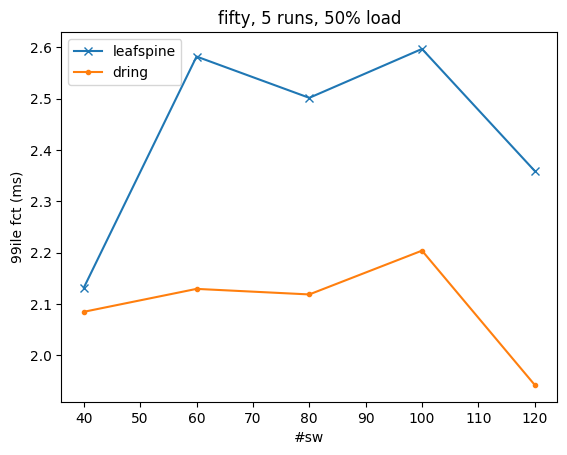

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

trafficname = "fifty"

homedir = "/u/az6922"
sumfile = f"{homedir}/DRing/src/emp/datacentre/experiments/scalability/{trafficname}.txt"
swlist = range(40,121,20)
sseedarr = range(1,6)

dringylist = list()
lsylist = list()
with open(sumfile,'r') as f:
    lines = f.readlines()
    for sw in swlist:
        dringseedlist = list()
        lsseedlist = list()
        for sseed in sseedarr:
            logfile = f"m_scalability_leafspine_{sw}_{sseed}.log"
            for line in lines:
                tokens = line.split()
                if tokens[0] == logfile:
                    n99fct = float(tokens[3])
                    lsseedlist.append(n99fct)
            logfile = f"m_scalability_dring_{sw}_{sseed}.log"
            for line in lines:
                tokens = line.split()
                if tokens[0] == logfile:
                    n99fct = float(tokens[3])
                    dringseedlist.append(n99fct)
        dringylist.append(sum(dringseedlist)/len(dringseedlist))
        lsylist.append(sum(lsseedlist)/len(lsseedlist))

plt.plot(swlist,lsylist,label="leafspine",marker='x')
plt.plot(swlist,dringylist,label="dring",marker='.')

plt.legend()
plt.xlabel('#sw')
plt.ylabel('99ile fct (ms)')
plt.title(f'{trafficname}, 5 runs, 50% load')
# plt.ylim(0,20)
# plt.savefig(f"{homedir}/DRing/src/emp/datacentre/experiments/scalability/{trafficname}.png", dpi=500)
plt.show()

delete

In [ ]:
import os

homedir = "/u/az6922"
dringdir = f"{homedir}/DRing/src/emp/datacentre"
for filedir in os.listdir(dringdir):
    if os.path.isfile(os.path.join(dringdir, filedir)):
        tokens = filedir.split("_")
        if tokens[0]=="m" and tokens[1]=="scalability" and tokens[-1].split('.')[-1]=="log":
            print(filedir)
            os.remove(f"{homedir}/DRing/src/emp/datacentre/{filedir}")
        if (tokens[0]=="rrg" or tokens[0]=="leafspine") and tokens[1]=="log":
            print(filedir)
            os.remove(f"{homedir}/DRing/src/emp/datacentre/{filedir}")
        if (tokens[-1]=="run") and ((tokens[0]=="leafspine" and tokens[1]=="leafspine") or (tokens[0]=="rrg" and (tokens[1]=="rrg" or tokens[1]=="dring"))):
            print(filedir)
            os.remove(f"{homedir}/DRing/src/emp/datacentre/{filedir}")